### 数据加载与探索

数据集维度: (5572, 2)
前5条数据:
   label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

标签分布:
 label
ham     4825
spam     747
Name: count, dtype: int64


D:\anaconda\envs\rurie\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\envs\rurie\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\envs\rurie\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\envs\rurie\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\envs\rurie\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.c

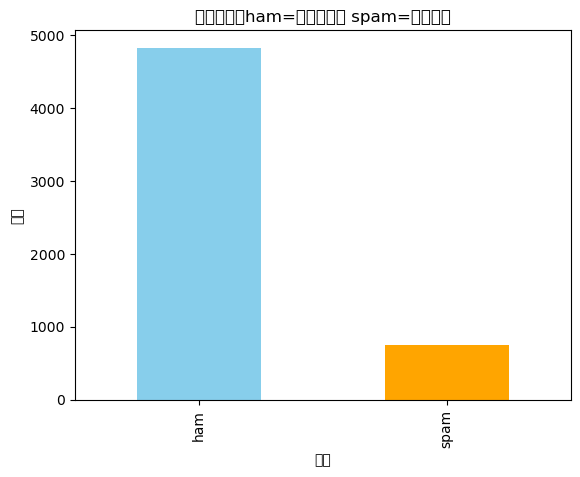

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = r"D:\AIdata\spam.csv"
df = pd.read_csv(file_path, encoding='latin-1')
df = df[['v1', 'v2']]  # 只保留标签和文本列
df.columns = ['label', 'text'] # 重命名列

# 查看数据基本信息
print("数据集维度:", df.shape)
print("前5条数据:\n", df.head())
print("\n标签分布:\n", df['label'].value_counts())

# 可视化标签分布
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title("标签分布（ham=正常邮件， spam=垃圾邮件")
plt.xlabel("类别")
plt.ylabel("数量")
plt.show()

### 数据预处理

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# 将标签转为二进制
df['label'] = df['label'].map({'ham':0, 'spam':1})

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# 文本向量化（将文本转换为词频矩阵）
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)  # 训练集向量化
X_test_vec = vectorizer.transform(X_test)  # 测试集向量化

print("\n训练集维度:", X_train_vec.shape)
print("测试集维度:", X_test_vec.shape)

print("NaN in y_train:", np.isnan(y_train).sum())
print("NaN in X_train_vec:", np.isnan(X_train_vec.toarray()).sum())



训练集维度: (4457, 7735)
测试集维度: (1115, 7735)
NaN in y_train: 0
NaN in X_train_vec: 0


### 手动实现朴素贝叶斯


In [31]:
class NaiveBayesManual:
    def __init__(self):
        self.class_probs = {} # 类别先验概率P(y)
        self.word_probs = {} # 条件概率P(x∣y)（每个词在类别中的概率）
        
    def fit(self, X, y):
        """训练模型：计算类别先验概率和条件概率"""
        n_samples, n_features = X.shape
        self.classes = np.unique(y) # 去重后的 y
        
        # 计算类别先验概率
        for cls in self.classes:
            self.class_probs[cls] = (np.sum(y == cls) + 1) / (n_samples + len(self.classes))
            
        # 计算条件概率（拉普拉斯平滑）
        self.word_probs = {cls: np.ones(n_features) for cls in self.classes} # 用全1向量初始化，确保每个类别都有概率
        
        for cls in self.classes:
            X_cls = X[y == cls]  # 提取X中属于cls类别的样本
            if X_cls.shape[0] == 0:  # 确保X_cls不是空的
                print(f"Warning: No samples found for class {cls}")
                continue
            total_words = X_cls.sum(axis=0) + 1 # 拉普拉斯平滑
            self.word_probs[cls] = (total_words + 1) / (np.sum(total_words) + n_features)
            
    def predict(self, X):
        """预测测试集"""
        y_pred = []
        """遍历X中每个样本x，计算其属于每个类别的后验概率（即P(y∣x)）"""
        for x in X:
            posteriors = {}
            for cls in self.classes:
                if cls not in self.word_probs or np.isnan(self.class_probs[cls]):
                    continue  # 避免 NaN
                word_prob = np.where(self.word_probs[cls] > 0, self.word_probs[cls], 1e-9)  # 避免 log(0)
                # 计算后验概率（对数形式避免下溢）
                posterior = np.log(self.class_probs[cls]) + np.sum(np.log(self.word_probs[cls]) * x)
                posteriors[cls] = posterior
            # 选择后概率最大的类别
            if posteriors:
                y_pred.append(max(posteriors, key=posteriors.get))
            else:
                y_pred.append(self.classes[0])  # 备用默认类别
        return np.array(y_pred)
    
# 训练手动实现的模型
manual_nb = NaiveBayesManual()
manual_nb.fit(X_train_vec.toarray(), y_train)

# 预测测试集
y_pred_manual = manual_nb.predict(X_test_vec.toarray())



### sklearn实现

In [32]:
from sklearn.naive_bayes import MultinomialNB
sklearn_nb = MultinomialNB()
sklearn_nb.fit(X_train_vec, y_train)

# 预测数据集
y_pred_sklearn = sklearn_nb.predict(X_test_vec)

# 查看模型参数（类别先验概率和条件概率）
print("\n类别先验概率:", sklearn_nb.class_log_prior_)
print("条件概率（部分）:\n", sklearn_nb.feature_log_prob_[:, :5])


类别先验概率: [-0.14380871 -2.01031406]
条件概率（部分）:
 [[-10.96028777 -10.96028777 -10.26714059 -10.96028777 -10.96028777]
 [ -7.78940856  -6.8085793   -9.98663313  -8.88802084  -9.29348595]]


### 模型评估与对比

In [33]:
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['ham', 'spam'])
    
    print(f"\n[{model_name}] 准确率: {acc:.3f}")
    print(f"[{model_name}] 混淆矩阵:\n", cm)
    print(f"[{model_name}] 分类报告:\n", report)

# 对比两个模型
evaluate_model(y_test, y_pred_manual, "手动实现朴素贝叶斯")
evaluate_model(y_test, y_pred_sklearn, "Scikit-learn朴素贝叶斯")


[手动实现朴素贝叶斯] 准确率: 0.978
[手动实现朴素贝叶斯] 混淆矩阵:
 [[962   3]
 [ 21 129]]
[手动实现朴素贝叶斯] 分类报告:
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       0.98      0.86      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115


[Scikit-learn朴素贝叶斯] 准确率: 0.984
[Scikit-learn朴素贝叶斯] 混淆矩阵:
 [[963   2]
 [ 16 134]]
[Scikit-learn朴素贝叶斯] 分类报告:
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       0.99      0.89      0.94       150

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

